# Classificação de Imagens de 38 classes de plantas por tipos de doenças, com Transfer Learning.

#### Objetivo: Analisar algumas redes com transfer learning e comparar os resultados, com base na variação de ajustes relacionados a parâmetros de Early Stop, Early Rate, camada Dropout, camada BatchNormalize e BatchSize.
#### Após análises dos dados de cada uma das 38 classes de imagens e por questão de performance, na execução limitada de processamento, a opção foi por utilizar somente 04 classes de status das condições de folhas de Uva, sendo que uma delas não continha imagens, sendo assim essa descartada.

##### Classes Consideradas:
###### Grape___Black_rot
###### Grape___Esca_(Black_Measles)
###### Grape___healthy


## Legenda:
#### Localização da base de dados no Kaggle: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
#### Base de dados de treino (trainpath): Já separada pelo autor da base de dados, em localização específica no Kaggle.
#### base de dados de validação (validpath): Já separada pelo autor da base de dados, em localização específica no Kaggle.
#### base de dados de teste (testepath): Preparada com algumas imagens da base de Treino que não foram submetidas ao treinamento do modelo.

## Consultas:
##### https://keras.io/applications/
##### https://www.tensorflow.org/tutorials/load_data/images
##### https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
##### https://keras.io/api/data_loading/
##### https://www.deeplearningbook.com.br/capitulo-23-como-funciona-o-dropout/
##### https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
##### https://keras.io/guides/transfer_learning/
##### https://www.deeplearningbook.com.br/?s=cap%C3%ADtulo+26
##### https://towardsdatascience.com/intuition-behind-log-loss-score-4e0c9979680a
##### https://wandb.ai/authors/ayusht/reports/Batch-Normalization-in-Keras-An-Example--VmlldzoxNzI5NjQ


## Leitura do local da base de dados

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
workdir_path = '/content/drive/MyDrive/TrabalhoFinal/DadosTCC/archive' #MODIFICAR!!! #Caminho para o seu workspace
os.chdir(workdir_path)

Mounted at /content/drive


In [2]:
os.path.abspath(os.getcwd())

'/content/drive/MyDrive/TrabalhoFinal/DadosTCC/archive'

In [3]:
# Base de imagens para treino com total de xx imagens (classes de tipos de platas)
trainpath = workdir_path + '/classeuva/Train'

# Base de imagens para validação com total de xx imagens (classes de tipos de platas)
validpath = workdir_path + '/classeuva/Valid'

# Base de imagens para validação com total de xx imagens (classes de tipos de platas)
testpath = workdir_path + '/classeuva/Test'

## Leitura de Bibliotecas

In [4]:
!pip install keras_tqdm
import numpy as np
import keras as ks
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential, Model,load_model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD
import os
import tensorflow_datasets as tfds
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from PIL import Image
# from keras.preprocessing.image import array_to_img, img_to_array, load_img
# from keras.applications.vgg16 import preprocess_input
from keras import losses
from tensorflow.keras.optimizers import RMSprop
from keras_tqdm import TQDMNotebookCallback
from random import randint
import matplotlib.pylab as plt




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Contagem das classes de treino

In [5]:
# Contar as imagens em cada pasta. Uma pasta = uma classe de planta

count=0
nomeplantas=[]
totalimagens=[]
for i in os.listdir(trainpath):
  count+=1
  nomeplantas.append(i)
  
  images_path=os.listdir(trainpath+"/"+i)
  totalimagens.append(len(images_path))


In [6]:
# Total de Classes de Plantas
len(nomeplantas)

3

## Contagem das classes de validação

In [7]:
# Contar as imagens em cada pasta. Uma pasta = uma classe de planta

count=0
nomeplantas=[]
totalimagens=[]
for i in os.listdir(validpath):
  count+=1
  nomeplantas.append(i)
  
  images_path=os.listdir(trainpath+"/"+i)
  totalimagens.append(len(images_path))


In [8]:
# Total de Classes de Plantas
len(nomeplantas)

3

## Tratar e  Carregar a Base de Treino
##### Ref: Como carregar imagens no Keras:
https://www.tensorflow.org/tutorials/load_data/images
##### A documentação da função que usa para carregar os dados (detalhes dos parâmetros):
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [9]:
# A carga da imagem é feita em lotes o tamanho de lote ("batch_size") de 32 imagens
batch_size = 32
# altura da imagem
img_height = 224
# largura da imagem
img_width = 224

In [10]:
# usar a função para carregar as imagens:
# https://www.tensorflow.org/tutorials/load_data/images
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

train_data = tf.keras.utils.image_dataset_from_directory(   # função para carregar imagens de treino
  trainpath,                                                # caminho onde estão as imagens de treino (diretório "raiz")
  labels='inferred',                                        
  label_mode='categorical',                                          
  image_size=(img_height, img_width),                       # largura e altura
  batch_size=batch_size)                                    # tamanho do lote


Found 4659 files belonging to 3 classes.


In [11]:
# verifica o nome das classes (são 03 pastas, cada pasta é uma classe)
train_data.class_names

['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy']

In [12]:
# visualizar o tipo de objeto retornado
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [13]:
# loop para ver a dimensão da imagem:
# 32 classes (pastas)
# 224 largura
# 224 altura
# 3 canais
# obs: Um break para evitar de percorrer todas as imagens
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  break

(32, 224, 224, 3)


In [14]:
# Normalizar as imagens de treino para estabelecer uma variação de valores entre [0..1]. Camada específica para isso.
# Fonte: Documentação Keras

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_data_normalized = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_data_normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.012084713 0.9315528


In [15]:
# Analisa o resultado da normalização da Base de Treino
for image_batch, labels_batch in train_data_normalized:
  print(image_batch.shape)
  break

(32, 224, 224, 3)


In [16]:
# Analisa o resultado da normalização da Base de Treino - Formato
train_data_normalized

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [17]:
# Analisa o resultado da normalização da Base de Treino - Matriz EGB
image_batch[5]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.08533415, 0.05000002, 0.05788318],
        [0.719848  , 0.6767107 , 0.692397  ],
        [0.63325334, 0.590116  , 0.6058023 ],
        ...,
        [0.61506563, 0.5719283 , 0.5640852 ],
        [0.6180875 , 0.5749502 , 0.567107  ],
        [0.5899554 , 0.54681814, 0.538975  ]],

       [[0.07316928, 0.04459786, 0.04571831],
        [0.6888756 , 0.64573836, 0.66142464],
        [0.7197079 , 0.67657065, 0.6922569 ],
        ...,
        [0.67665166, 0.6335144 , 0.62567127],
        [0.66992766, 0.6267904 , 0.61894727],
        [0.66538626, 0.622249  , 0.6144059 ]],

       [[0.08149262, 0.04771911, 0.05404164],
        [0.67422974, 0.6310925 , 0.64677876],
        [0.68931574, 0.6461785 , 0.66186476],
        ...,
        [0.60081947, 0.5576822 , 0.5498391 ],
        [0.62144905, 0.5783118 , 0.57046866],
        [0.58689386, 0.5437566 , 0.53591347]],

       ...,

       [[0.07741106, 0.04415768, 0.05780322],
        [0.66

## Tratar e  Carregar a Base de Validação
## Ref: Como carregar imagens no Keras:
https://www.tensorflow.org/tutorials/load_data/images
## A documentação da função que usa para carregar os dados (detalhes dos parâmetros):
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [18]:
# A carga da imagem é feita em lotes o tamanho de lote ("batch_size") de 32 imagens
batch_size = 32
# altura da imagem
img_height = 224
# largura da imagem
img_width = 224

In [19]:
# usar a função para carregar as imagens:
# https://www.tensorflow.org/tutorials/load_data/images
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

valid_data = tf.keras.utils.image_dataset_from_directory(   # função para carregar imagens de validação
  validpath,                                                # caminho onde estão as imagens de validação (diretório "raiz")
  labels='inferred',                                        
  label_mode='categorical',                                 
  image_size=(img_height, img_width),                       # largura e altura
  batch_size=batch_size)                                    # tamanho do lote

Found 1169 files belonging to 3 classes.


In [20]:
# verifica o nome das classes (são 03 pastas, cada pasta é uma classe)
valid_data.class_names

['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy']

In [21]:
# visualizar o tipo de objeto retornado
valid_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [22]:
# loop para ver a dimensão da imagem:
# obs: Um break para evitar de percorrer todas as imagens
for image_batch, labels_batch in valid_data:
  print(image_batch.shape)
  break

(32, 224, 224, 3)


In [23]:
# Normalizar as imagens de validação para estabelecer uma variação de valores entre [0..1]. Camada específica para isso.
# Fonte: Documentação Keras

normalization_layer = tf.keras.layers.Rescaling(1./255)
valid_data_normalized = valid_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(valid_data_normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.0 0.96958995


In [24]:
# Analisa o resultado da normalização da Base de Validação
for image_batch, labels_batch in valid_data_normalized:
  print(image_batch.shape)
  break

(32, 224, 224, 3)


In [25]:
# Analisa o resultado da normalização da Base de Validação - Formato
valid_data_normalized

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [26]:
# Analisa o resultado da normalização da Base de Validação - Matriz EGB
image_batch[2]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.75564235, 0.7477992 , 0.7517208 ],
        [0.75582236, 0.7479792 , 0.7519008 ],
        [0.6379352 , 0.6300921 , 0.63401365],
        ...,
        [0.60020053, 0.568828  , 0.5570633 ],
        [0.62465   , 0.59327745, 0.58151275],
        [0.59855896, 0.5671864 , 0.5554217 ]],

       [[0.839816  , 0.83197284, 0.8358944 ],
        [0.79741895, 0.7895758 , 0.7934974 ],
        [0.72927177, 0.72142863, 0.7253502 ],
        ...,
        [0.59783953, 0.566467  , 0.5547023 ],
        [0.61716694, 0.5857944 , 0.5740297 ],
        [0.6013803 , 0.57000774, 0.55824304]],

       [[0.762505  , 0.75466186, 0.7585834 ],
        [0.7612846 , 0.75344145, 0.757363  ],
        [0.81300527, 0.80516213, 0.8090837 ],
        ...,
        [0.5866948 , 0.55532223, 0.5435575 ],
        [0.5921769 , 0.56080437, 0.54903966],
        [0.5968789 , 0.56550634, 0.55374163]],

       ...,

       [[0.6675273 , 0.6596842 , 0.66360575],
        [0.67

## Resumo Leitura de Imagens
##### 4659 +-(80%) treino, 1169 (20%) validação e xxxxx total de imagens

## Modelo de Classificação RESNET50 sem Transfer Learning e Data Augmentation
##### Analisar a resposta da classificação

In [27]:
## Código consultado no Keras https://keras.io/api/applications/


model = ResNet50(weights='imagenet', input_shape=(img_height,img_width,3))

# Carrega uma imagem de uma classe (Treino) para verificar a predição nessa Rede, nessas condições.
img = image.load_img(trainpath+"/Grape___healthy/ac753212-e6d7-44b9-9722-4413a7418ab3___Mt.N.V_HL 6178_180deg.JPG", target_size=(img_height,img_width,3))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=4)[0])


35363/35363 [==============================] - 0s 0us/step
Predicted: [('n03991062', 'pot', 0.944409), ('n07745940', 'strawberry', 0.022876952), ('n12768682', 'buckeye', 0.006580505), ('n12620546', 'hip', 0.0028070554)]


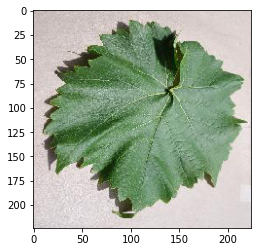

In [28]:
# Avaliação da assertividade para a classe Tomato___Tomato_mosaic_virus da base de treino
import matplotlib.pylab as plt
plt.imshow(img)

Modelo nessa condição não obteve sucesso na identificação de uma imagem de uma classe. O que era previsto somente comprovando a necessidade de treinar um modelo aplicando Transfer Learning.

In [29]:
# Visualização das Camadas do Modelo RESNET50 sem Transfer Learning e Data Augmentation
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

## Analisa Camadas RESNET50 Truncada

In [30]:
base_model_tf=ResNet50(weights='imagenet',classes=3,include_top = False)

#Model building
base_model_tf.trainable=False

base_model_tf.summary()


94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                          

In [31]:
## API Keras https://keras.io/guides/functional_api/
## https://keras.io/guides/sequential_model/

## Modelo RESNET50 Base para Aplicar Transfer Learning


In [32]:
# Modelo Truncado:
modelo_base = ResNet50(weights='imagenet', classes=3, input_shape=(img_height,img_width,3),include_top=False)
# "Congelar" as camadas superiores (manter os pesos):
modelo_base.trainable=False
modelo_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

## Modelo RESNET50 Truncado + Camada Dense

*   Aproveitar a base de conhecimento RESNET50 (Imagenet) e seus pesos
*   Treinar essa base adicionando as novas Classes de Treino das Imagens Coletadas



In [33]:
# from tensorflow.keras.layers import Flatten
sh=Input(shape=(img_height,img_width,3)) # Formato de entrada imagem
conv=tf.cast(sh,tf.float32) 
modelo_dense_1=modelo_base(conv,training=False) 
modelo_dense_1=GlobalAveragePooling2D()(modelo_dense_1)
modelo_dense_1=Dropout(0.2)(modelo_dense_1)
modelo_dense_1=Dense(128,activation='relu')(modelo_dense_1)
modelo_dense_1=Dense(64,activation='relu')(modelo_dense_1)
modelo_dense_1=Dense(3,activation='softmax')(modelo_dense_1)

from keras.models import Model
modelo_final_1=Model(inputs=sh,outputs=modelo_dense_1)
modelo_final_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                             

In [34]:
modelo_final_1.layers

In [35]:
# Definie as métricas
earlystp=EarlyStopping(patience=25, monitor='val_loss') # Evitar um Overfiting do Modelo
metrics = ['accuracy',Precision(),Recall(), AUC()]

In [36]:
# Compila o Modelo
modelo_final_1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01),metrics=metrics)

In [37]:
# Processa o modelo com Transfer Learning usando a base de imagens de Treino Normalizada e a base de Validação Normalizada
modelo_final_1_Hist = modelo_final_1.fit(train_data_normalized,validation_data=valid_data_normalized,epochs=200, verbose=1,callbacks=[earlystp])


Epoch 1/200
146/146 [==============================] - 564s 4s/step - loss: 0.9723 - accuracy: 0.5460 - precision: 0.5922 - recall: 0.3902 - auc: 0.7455 - val_loss: 0.6232 - val_accuracy: 0.7074 - val_precision: 0.7171 - val_recall: 0.6938 - val_auc: 0.8871
Epoch 2/200
146/146 [==============================] - 22s 144ms/step - loss: 0.7060 - accuracy: 0.6634 - precision: 0.6814 - recall: 0.6203 - auc: 0.8522 - val_loss: 0.5912 - val_accuracy: 0.7066 - val_precision: 0.7114 - val_recall: 0.6852 - val_auc: 0.8931
Epoch 3/200
146/146 [==============================] - 21s 139ms/step - loss: 0.6610 - accuracy: 0.6989 - precision: 0.7089 - recall: 0.6748 - auc: 0.8730 - val_loss: 0.5481 - val_accuracy: 0.7656 - val_precision: 0.7721 - val_recall: 0.7246 - val_auc: 0.9196
Epoch 4/200
146/146 [==============================] - 21s 138ms/step - loss: 0.6131 - accuracy: 0.7235 - precision: 0.7307 - recall: 0.7029 - auc: 0.8899 - val_loss: 0.5612 - val_accuracy: 0.7519 - val_precision: 0.7671 -

In [38]:
modelo_final_1.save('/content/drive/MyDrive/TrabalhoFinal/DadosTCC/archive/Inferência-TestesModelos/Caso de Teste 03/Resnet50-cenário04-i2/Modelo_Salvo_1/Resnet50.h5')

## Análise da RESNET50 - Transfer Learning
##### Métricas:
###### Acurácia: Taxa de acerto do modelo - VP + VN / (VP+VN+FN+FP). Pode mascarar falso positivo e falso negativo.
###### Recall: Taxa de VP entre todas as classes positivas. Varia de 0 a 1 , quanto maior o valor melhor - VP / VP + FN
###### Precisão: Taxa de VP entre os valores Positivos Preditos. VP / VP+FP. Quanto menor a qtd de falsos alarmes melhor.
###### AUC: Relação com a curva ROC (Receiver Operating Characteristic). É a área sob a curva e é recomendada para comparar modelos diferentes. Varia entre 0 e 1 e quanto maior o valor melhor a classificação.


In [39]:
print(modelo_final_1_Hist.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


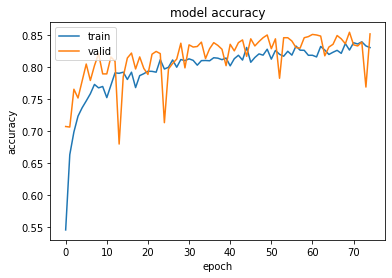

In [40]:
plt.plot(modelo_final_1_Hist.history['accuracy'])
plt.plot(modelo_final_1_Hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

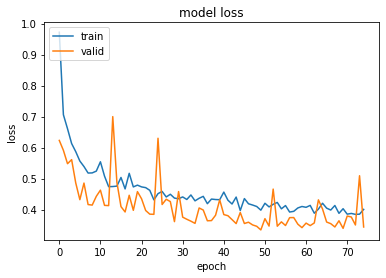

In [41]:
plt.plot(modelo_final_1_Hist.history['loss'])
plt.plot(modelo_final_1_Hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

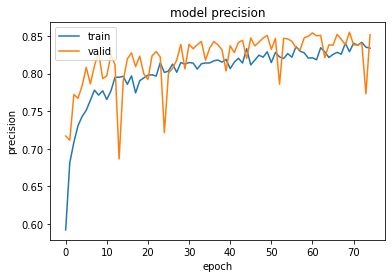

In [42]:
plt.plot(modelo_final_1_Hist.history['precision'])
plt.plot(modelo_final_1_Hist.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

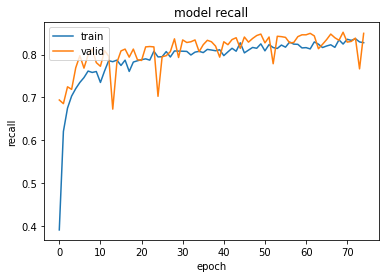

In [43]:
plt.plot(modelo_final_1_Hist.history['recall'])
plt.plot(modelo_final_1_Hist.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

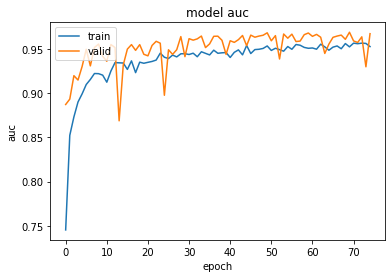

In [44]:
plt.plot(modelo_final_1_Hist.history['auc'])
plt.plot(modelo_final_1_Hist.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()